In [7]:
#Importamos librerias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.signal import butter, lfilter, cheb2ord, cheby2
from scipy.signal import iirnotch, iirfilter, buttord, firwin
from tqdm import tqdm

In [4]:
#Abrimos el archivo txt
f = open("ECG_respriacion_despues_ejercicio.txt","r")
raw_data = f.readline()  # con f.read() leemos todo el contenido
f.close()
raw_data

Fs = 1000
Ts = 1/Fs
print(f" Fs = {Fs} hz\n Ts = {Ts} s")

#Leer el archivo excluyendo las 2 primeras filas 
array = np.genfromtxt("./ECG_respriacion_despues_ejercicio.txt", skip_header = 2)
#array[filas, columnas]
canalA2 = array[:,6] #Todas las filas de la columna 6 -> Canal A2 ECG
num_samples = canalA2.shape[0]

VCC = 3.3 # Voltaje de operación
#(4 primeros canales -> n = 10 bits de resolución)
#(2 últimos canales -> n = 6 bits de resolución)
n = 10 #Número de bits del canal
EEG_V = (((canalA2/pow(2,n))-0.5)* VCC)/num_samples
EEG_uV = EEG_V*pow(10,6)

 Fs = 1000 hz
 Ts = 0.001 s


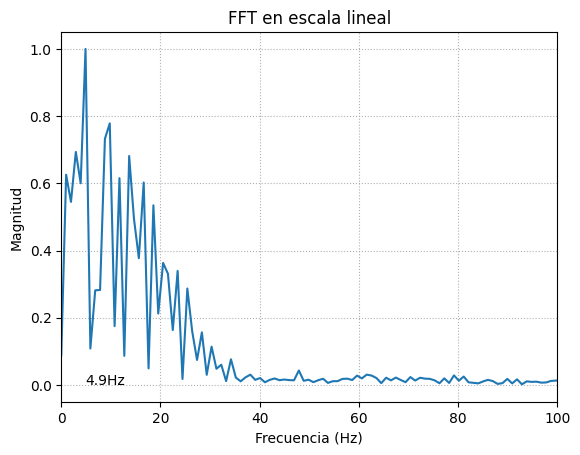

In [5]:
N = 2**10  # 10 bits, 0-1023

signal_fft = np.fft.fft(EEG_uV, N)  # FFT de la señal
signal_fft = np.round(np.abs(signal_fft), 3)  # Magnitud de la FFT
signal_aux = signal_fft / signal_fft.max()  # Normalización de la magnitud

F_list = np.linspace(0, Fs, N)  # Rango completo de frecuencias

F = np.round(F_list[np.argmax(signal_aux)], 1)  # Frecuencia máxima

plt.plot(F_list, signal_aux)
plt.text(F, 0, f"{F}Hz")
plt.grid(linestyle=":")
plt.ylabel("Magnitud")
plt.xlabel("Frecuencia (Hz)")
plt.title("FFT en escala lineal")
plt.xlim([0, 100])  # Ajuste del rango de frecuencias
plt.show()

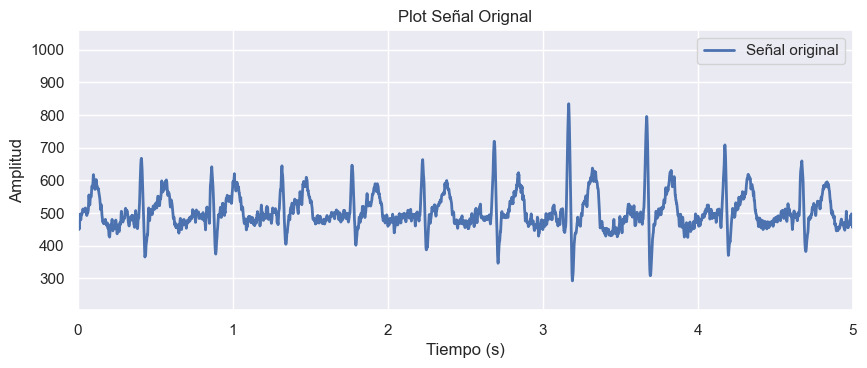

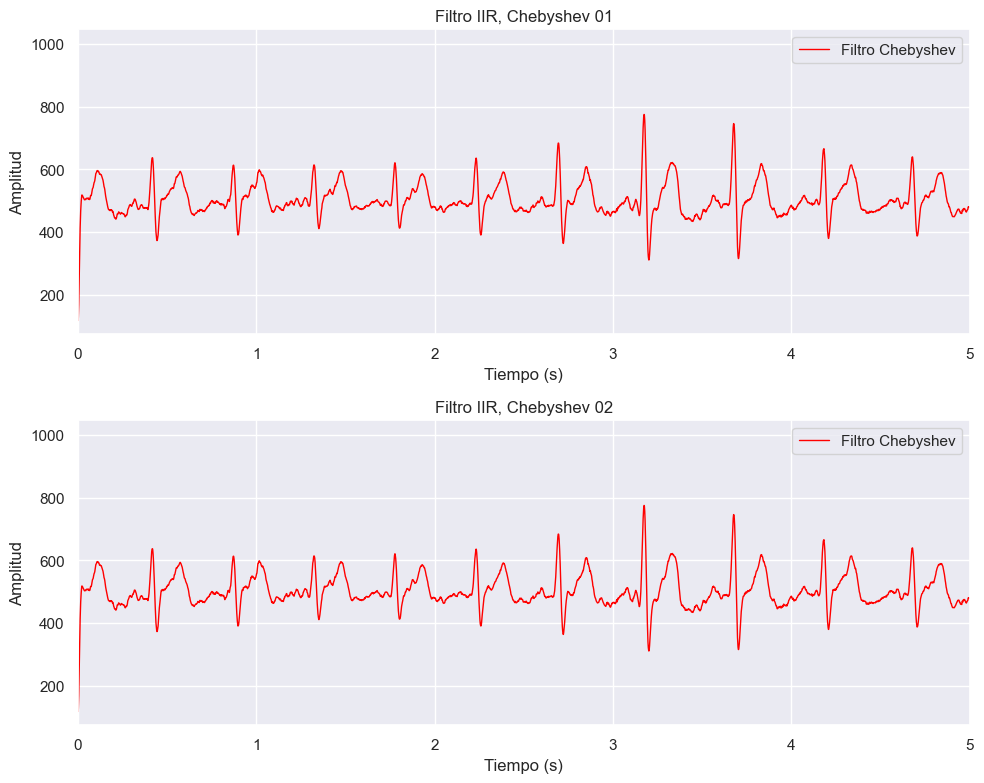

In [17]:
# Leer los datos del archivo txt
array = np.genfromtxt("ECG_despues_ejercicio.txt", skip_header=2)
canalA2 = array[:, 6]  # Obtener los datos del canal A2

# Definir parámetros de la señal
Fs = 1000
Ts = 1 / Fs
t = np.arange(0, len(canalA2)) * Ts

# Funciones de filtro
def cheby_lowpass(wp, ws, fs, gpass, gstop):
    wp = wp / fs
    ws = ws / fs
    order, wn = cheb2ord(wp, ws, gpass, gstop)
    b, a = cheby2(order, gstop, wn)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def cheby_lowpass_filter(data, cutoff, fs, gpass, gstop):
    b, a = cheby_lowpass(cutoff[0], cutoff[1], fs, gpass, gstop)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Definir parámetros de los filtros
order = 10
band = 99.5  # ancho de banda
disp = 10  # desplazamiento
cutoff = 80  # frecuencia de corte deseada del filtro, Hz

cheby_freq = [(cutoff + disp) - band / 2, (cutoff + disp) + band / 2]

# Filtrar los datos
y1 = butter_lowpass_filter(canalA2, cutoff, Fs, order)
y2 = butter_lowpass_filter(canalA2, cutoff, Fs, order)
z1 = cheby_lowpass_filter(canalA2, cheby_freq, Fs, 1, 10)
z2 = cheby_lowpass_filter(canalA2, cheby_freq, Fs, 1, 10)

# Graficar
sns.set()
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(t, canalA2, linewidth=2, label='Señal original')
plt.title('Plot Señal Orignal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0,5])
plt.legend()
plt.grid(True)

sns.set()
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t, z1, linewidth=1, label='Filtro Chebyshev', color='red')
plt.title('Filtro IIR, Chebyshev 01')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0,5])
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, z2, linewidth=1, label='Filtro Chebyshev', color='red')
plt.title('Filtro IIR, Chebyshev 02')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0,5])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


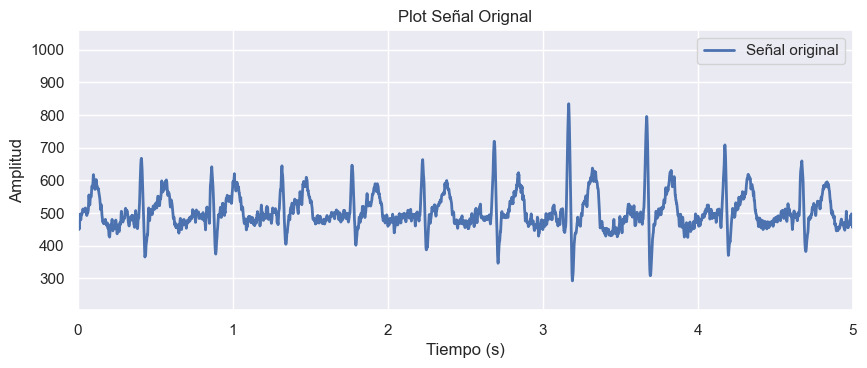

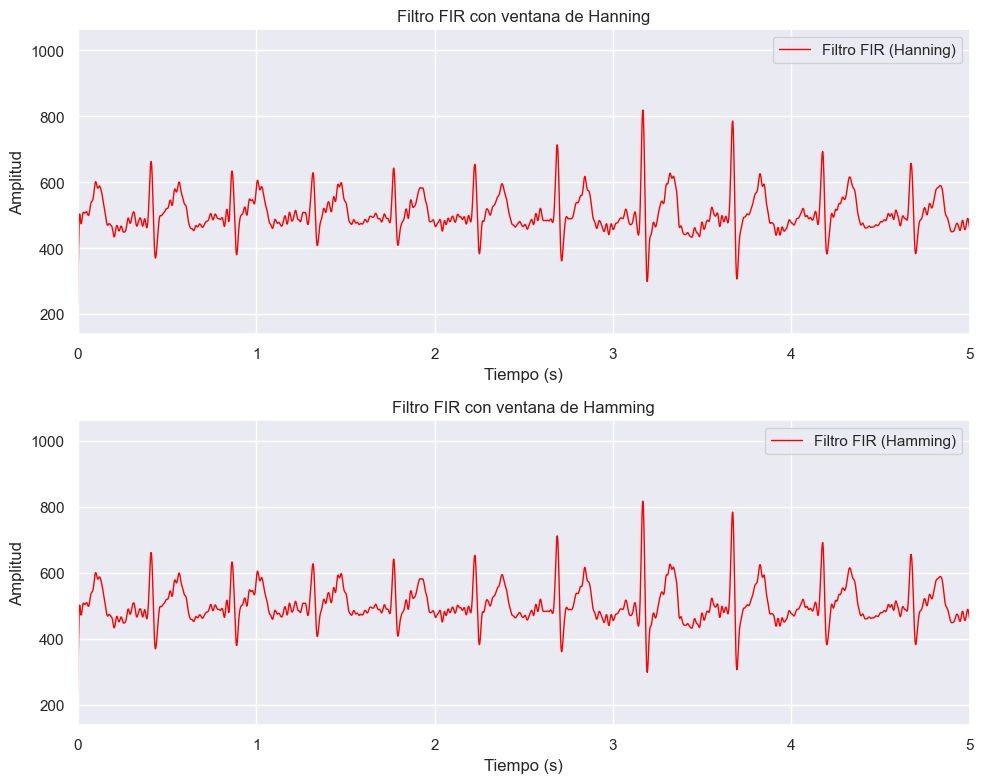

In [18]:
# Definir función para diseñar un filtro FIR con una ventana específica
def fir_lowpass_window(cutoff, fs, num_taps=100, window='hamming'):
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    taps = firwin(num_taps, cutoff_norm, window=window)
    return taps

# Parámetros del filtro FIR
cutoff_fir = 50  # Frecuencia de corte del filtro FIR
num_taps = 100  # Número de coeficientes del filtro FIR

# Filtrar los datos con el filtro FIR utilizando la ventana de Hanning
taps_hanning = fir_lowpass_window(cutoff_fir, Fs, num_taps, window='hann')
y_fir_hanning = np.convolve(canalA2, taps_hanning, mode='same')

# Filtrar los datos con el filtro FIR utilizando la ventana de Hamming
taps_hamming = fir_lowpass_window(cutoff_fir, Fs, num_taps, window='hamming')
y_fir_hamming = np.convolve(canalA2, taps_hamming, mode='same')

# Graficar

# Graficar
sns.set()
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(t, canalA2, linewidth=2, label='Señal original')
plt.title('Plot Señal Orignal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0,5])
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_fir_hanning, linewidth=1, label='Filtro FIR (Hanning)', color='red')
plt.title('Filtro FIR con ventana de Hanning')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0, 5])
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_fir_hamming, linewidth=1, label='Filtro FIR (Hamming)', color='red')
plt.title('Filtro FIR con ventana de Hamming')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0, 5])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
